In [18]:
# Comparison
# Receiver Operating Characterisc curve

In [19]:
# Logistic Regression

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL - LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')


In [20]:
# KNN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Load Dataset
dataset = pd.read_csv("riceclass.csv")

X = dataset.drop("Class", axis = 1)
X = X.drop("id", axis = 1)
y = dataset["Class"]

scaler = MinMaxScaler(feature_range = (0, 1))
X_rescaled = scaler.fit_transform(X)
X = pd.DataFrame(data = X_rescaled, columns = X.columns)

set_of_classes = y.value_counts().index.tolist()
set_of_classes = pd.DataFrame({"Class": set_of_classes})
y = pd.get_dummies(y)

# Split Dataset
data_train, data_test, class_train, class_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

k = 65

knn_65 = KNeighborsClassifier(k)

knn_65.fit(data_train, class_train)

y_pred_65 = knn_65.predict(data_test)

print("Accuracy with k = 65 for full model: ", accuracy_score(class_test, y_pred_65) * 100)




Accuracy with k = 65 for full model:  92.91338582677166


c:\Users\desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [21]:
# Neural Network

import pandas as pd
import torch
import numpy as np
from torch import nn, optim
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# Basically is the program that we'll use to train the data
# If cuda and backends isn't available, the cpu is used by default
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

# The neural network class
# Input Node Size: 7 Input
# Output Node Size: 1 Output (What type of rice it is)
# Hidden/Output Activation: Sigmoid 
# Input: Linear combination
class NeuralNetwork(nn.Module):
    def __init__(self, input_val, hidden_layers):
        super().__init__() # Inheriting the previous initialzied values from nn.Module
        self.input = nn.Linear(input_val, hidden_layers[0]).to(torch.float32)
        # nn.Module is basically python's list that can store modules.
        self.hidden = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]).to(torch.float32) for i in range(len(hidden_layers) - 1)])
        self.output = nn.Linear(hidden_layers[-1], 1).to(torch.float32)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.input(x))
        # Iterate through the hidden layer, where the Linear input (item) passes through the activation function Sigmoid
        for items in self.hidden:
            x = self.sigmoid(items(x))
        x = self.output(x)
        return x



df = pd.read_csv("riceclass.csv")

df_input = df.drop(["id", "Class"], axis = 1)
df_output = df["Class"]

# Apply label encoding
label_encoder = LabelEncoder()
df_output = label_encoder.fit_transform(df_output)

# Min Max Scalar
scale = MinMaxScaler(feature_range=(0, 1))
input_rescale = scale.fit_transform(df_input)
df_input = pd.DataFrame(data = input_rescale, columns = df_input.columns)


# 
inputTensor = torch.tensor(df_input.to_numpy(), dtype = torch.float32)
outputTensor = torch.tensor(df_output, dtype = torch.float32)

# Train Test Split (80% Train)
tensorDf = torch.utils.data.TensorDataset(inputTensor, outputTensor)
train_amount = int(0.8 * len(df))
test_amount = len(df) - train_amount
train_df, test_df = torch.utils.data.random_split(tensorDf, [train_amount, test_amount])

# Set up our Neural network variables
input_size = 7
hidden_layer_size = [12, 24, 48]
learning_rate = 0.01
amount_epochs = 1000

# Create the model ()
model = NeuralNetwork(input_size, hidden_layer_size)

# Set up loss functions for backward propagation and optimizeers
loss = nn.BCEWithLogitsLoss() 
optimize = optim.Adam(model.parameters(), lr = learning_rate)

# Batch SGD

train_data_loader = DataLoader(train_df, batch_size = 300, shuffle = True)

for epochs in range(amount_epochs):
    for input_val, output_val in train_data_loader:
        optimize.zero_grad()
        # Use the model with the input data, where result are the outputs.
        result = model(input_val)
        # Back propagation with optimizer
        # view transposes the output_val for comparison
        lossResult = loss(result, output_val.view(-1,1))
        lossResult.backward()
        optimize.step()

    # Print progress
    if (epochs + 1) % 100 == 0:
        print(f'Epoch [{epochs+1}/{amount_epochs}], Loss: {lossResult.item():.4f}')


# Comparison with test data
model.eval() # PyTorch  
test_data_loader = DataLoader(test_df, batch_size = 300, shuffle = True)

correct_ans = 0
total_ans = 0
for input_val, output_val in test_data_loader:
    # Use the model with the input data, where result are the outputs.
    result = model(input_val)
    round_result = torch.round(torch.sigmoid(result)) # Rounds the answer so that it goes to 0 or 1 for MSE analysis
    total_ans += output_val.view(-1,1).size(0)
    # item() converts from torch to python integer
    correct_ans += (round_result == output_val.view(-1,1)).sum().item()





Epoch [100/1000], Loss: 0.2135
Epoch [200/1000], Loss: 0.1706
Epoch [300/1000], Loss: 0.1204
Epoch [400/1000], Loss: 0.1681
Epoch [500/1000], Loss: 0.3217
Epoch [600/1000], Loss: 0.0790
Epoch [700/1000], Loss: 0.2596
Epoch [800/1000], Loss: 0.3049
Epoch [900/1000], Loss: 0.2437
Epoch [1000/1000], Loss: 0.1941


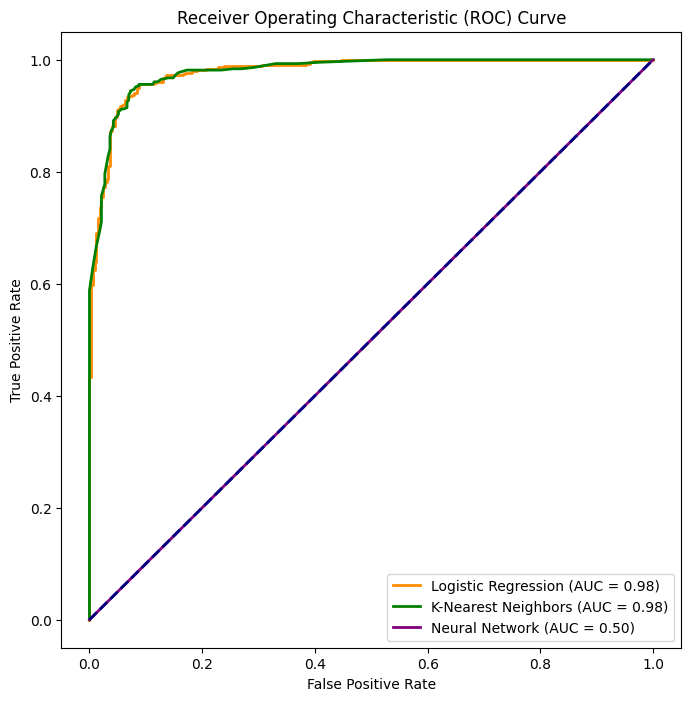

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
import torch
from torch import nn, optim
from skorch import NeuralNetClassifier
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Standardize/Scale the data
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train)
X_test_lr_scaled = scaler_lr.transform(X_test)

scaler_knn = MinMaxScaler(feature_range=(0, 1))
X_train_knn_scaled = scaler_knn.fit_transform(X_train)
X_test_knn_scaled = scaler_knn.transform(X_test)

# Encode labels for roc_curve
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr_scaled, y_train)
logreg_probs = logreg.predict_proba(X_test_lr_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test_encoded, logreg_probs)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=65)  # Assuming 65 is the best k value from your tuning
knn.fit(X_train_knn_scaled, y_train)
knn_probs = knn.predict_proba(X_test_knn_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test_encoded, knn_probs)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Neural Network
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = X.shape[1]
hidden_layer_size = [12, 24, 48]
learning_rate = 0.01
amount_epochs = 1000

class NeuralNetwork(nn.Module):
    def __init__(self, input_val, hidden_layers):
        super().__init__()
        self.input = nn.Linear(input_val, hidden_layers[0]).to(torch.float32)
        self.hidden = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]).to(torch.float32) for i in range(len(hidden_layers) - 1)])
        self.output = nn.Linear(hidden_layers[-1], 1).to(torch.float32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.input(x))
        for items in self.hidden:
            x = self.sigmoid(items(x))
        x = self.output(x)
        return x

model_nn = NeuralNetwork(input_size, hidden_layer_size)
optimizer_nn = optim.Adam(model_nn.parameters(), lr=learning_rate)
criterion_nn = nn.BCEWithLogitsLoss()

# Encode labels for neural network training
label_encoder_nn = LabelEncoder()
y_train_encoded_nn = label_encoder_nn.fit_transform(y_train)

X_train_nn = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_nn = torch.tensor(y_train_encoded_nn, dtype=torch.float32)
X_test_nn = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

train_data_nn = TensorDataset(X_train_nn, y_train_nn)
train_loader_nn = DataLoader(train_data_nn, batch_size=300, shuffle=True)

for epoch in range(amount_epochs):
    for inputs, labels in train_loader_nn:
        optimizer_nn.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion_nn(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_nn.step()

model_nn.eval()
with torch.no_grad():
    y_probs_nn = torch.sigmoid(model_nn(X_test_nn)).numpy()
fpr_nn, tpr_nn, _ = roc_curve(y_test_encoded, y_probs_nn)
roc_auc_nn = auc(fpr_nn, tpr_nn)

# Plotting ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label=f'K-Nearest Neighbors (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_nn, tpr_nn, color='purple', lw=2, label=f'Neural Network (AUC = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neural_network import MLPClassifier
import torch
from torch import nn, optim
from skorch import NeuralNetClassifier
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
dataset = pd.read_csv('riceclass.csv')
X = dataset.drop(['Class', 'id'], axis=1)
y = dataset['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

# Standardize/Scale the data
scaler_lr = StandardScaler()
X_train_lr_scaled = scaler_lr.fit_transform(X_train)
X_test_lr_scaled = scaler_lr.transform(X_test)

scaler_knn = MinMaxScaler(feature_range=(0, 1))
X_train_knn_scaled = scaler_knn.fit_transform(X_train)
X_test_knn_scaled = scaler_knn.transform(X_test)

# Encode labels for roc_curve
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_lr_scaled, y_train)
y_pred_lr = logreg.predict(X_test_lr_scaled)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=65)  # Assuming 65 is the best k value from your tuning
knn.fit(X_train_knn_scaled, y_train)
y_pred_knn = knn.predict(X_test_knn_scaled)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')

# Neural Network
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = X.shape[1]
hidden_layer_size = [12, 24, 48]
learning_rate = 0.01
amount_epochs = 1000

class NeuralNetwork(nn.Module):
    def __init__(self, input_val, hidden_layers):
        super().__init__()
        self.input = nn.Linear(input_val, hidden_layers[0]).to(torch.float32)
        self.hidden = nn.ModuleList([nn.Linear(hidden_layers[i], hidden_layers[i+1]).to(torch.float32) for i in range(len(hidden_layers) - 1)])
        self.output = nn.Linear(hidden_layers[-1], 1).to(torch.float32)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.input(x))
        for items in self.hidden:
            x = self.sigmoid(items(x))
        x = self.output(x)
        return x

model_nn = NeuralNetwork(input_size, hidden_layer_size)
optimizer_nn = optim.Adam(model_nn.parameters(), lr=learning_rate)
criterion_nn = nn.BCEWithLogitsLoss()

# Encode labels for neural network training
label_encoder_nn = LabelEncoder()
y_train_encoded_nn = label_encoder_nn.fit_transform(y_train)

X_train_nn = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_nn = torch.tensor(y_train_encoded_nn, dtype=torch.float32)
X_test_nn = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

train_data_nn = TensorDataset(X_train_nn, y_train_nn)
train_loader_nn = DataLoader(train_data_nn, batch_size=300, shuffle=True)

for epoch in range(amount_epochs):
    for inputs, labels in train_loader_nn:
        optimizer_nn.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion_nn(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer_nn.step()

model_nn.eval()
with torch.no_grad():
    y_probs_nn = torch.sigmoid(model_nn(X_test_nn)).numpy()
y_pred_nn = torch.round(torch.sigmoid(model_nn(X_test_nn))).detach().numpy()
conf_matrix_nn = confusion_matrix(y_test_encoded, y_pred_nn)

accuracy_nn = accuracy_score(y_test_encoded, y_pred_nn)
precision_nn = precision_score(y_test_encoded, y_pred_nn, average='weighted')
recall_nn = recall_score(y_test_encoded, y_pred_nn, average='weighted')
f1_nn = f1_score(y_test_encoded, y_pred_nn, average='weighted')

# Print the results
print("Logistic Regression Confusion Matrix:")
print(conf_matrix_lr)
print("Accuracy: {:.4f}".format(accuracy_lr))
print("Precision: {:.4f}".format(precision_lr))
print("Recall: {:.4f}".format(recall_lr))
print("F1 Score: {:.4f}".format(f1_lr))
print()

print("K-Nearest Neighbors Confusion Matrix:")
print(conf_matrix_knn)
print("Accuracy: {:.4f}".format(accuracy_knn))
print("Precision: {:.4f}".format(precision_knn))
print("Recall: {:.4f}".format(recall_knn))
print("F1 Score: {:.4f}".format(f1_knn))
print()

print("Neural Network Confusion Matrix:")
print(conf_matrix_nn)
print("Accuracy: {:.4f}".format(accuracy_nn))
print("Precision: {:.4f}".format(precision_nn))
print("Recall: {:.4f}".format(recall_nn))
print("F1 Score: {:.4f}".format(f1_nn))

c:\Users\desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Logistic Regression Confusion Matrix:
[[302  28]
 [ 22 410]]
Accuracy: 0.9344
Precision: 0.9344
Recall: 0.9344
F1 Score: 0.9343

K-Nearest Neighbors Confusion Matrix:
[[303  27]
 [ 21 411]]
Accuracy: 0.9370
Precision: 0.9370
Recall: 0.9370
F1 Score: 0.9369

Neural Network Confusion Matrix:
[[  0 330]
 [  0 432]]
Accuracy: 0.5669
Precision: 0.3214
Recall: 0.5669
F1 Score: 0.4102


c:\Users\desktop\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
